In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import numpy as np

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


2024-01-17 10:36:30.433416: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-17 10:36:30.509077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 10:36:30.509132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 10:36:30.511416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 10:36:30.526650: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-01-17 10:36:33.007637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 10:36:33.073669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 10:36:33.073874: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

""" #feats = np.load(feats_path)
#print("feats shape: ", feats.shape)
y = y[:, 0] # only use laser power
print("y shape: ", y.shape)

# normalize y
y = y / np.max(y) """

# use laser power and velocity as labels
y = y[:, :2]
print("y shape: ", y.shape)

# print max of each column
print("max of each column: ", np.max(y, axis=0))
# normalize y by dividing laser power by max of each column
y = y / np.max(y, axis=0)

manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
y shape:  (9587, 2)
max of each column:  [2750   15]


In [3]:
# create a function to encode y
def encode_one_column(y):
    # create a new array of zeros with the same shape as y
    encoded_y = np.zeros(y.shape)
    # get the unique values in y
    unique_values = np.unique(y)
    # loop through the unique values
    for i, value in enumerate(unique_values):
        # find the indices where y equals the unique value
        indices = np.where(y == value)
        # set the indices in encoded_y to i
        encoded_y[indices] = i
    return encoded_y

# create new array to store encoded y
y_encoded = np.zeros(y.shape)
# loop through each column in y and encode it
for i in range(y.shape[1]):
    y_encoded[:, i] = encode_one_column(y[:, i])
    
# convert to int
y_encoded = y_encoded.astype(int)
y_encoded.shape

(9587, 2)

In [4]:
# concatenate manta and xiris images with label y_encoded as rows
# concatenate the two inputs (manta and xiris) along rows
x = np.concatenate((manta, xiris), axis=0)
y = np.concatenate((y_encoded, y_encoded), axis=0)
print("x shape: ", x.shape)
print("y shape: ", y.shape)

# split data into train and test (manta as input and y as output) with shuffle as true
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
 

x shape:  (19174, 320, 320)
y shape:  (19174, 2)
x_train shape:  (15339, 320, 320)
y_train shape:  (15339, 2)
x_test shape:  (3835, 320, 320)
y_test shape:  (3835, 2)


In [5]:
del manta, xiris, y, y_encoded, x

In [6]:
import tensorflow_addons as tfa

def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

# add projection head
def add_projection_head(input_shape, encoder, embedding_dim):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    
    contrastive_outputs = [Dense(embedding_dim, activation='linear', name=f"contrastive_output_{i}")(features) for i in range(num_tasks)]

    model = Model(inputs=inputs, outputs=contrastive_outputs)
    return model

input_shape = (320, 320, 1)
embedding_dim = 128
num_tasks = 2
 
encoder = create_encoder(input_shape)
# build model
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim)
# summarize model
encoder_with_projection_head.summary()

class SupConModel(Model):
    def __init__(self, sup_model, temperature=0.05):
        super().__init__()
        self.sup_model = sup_model
        self.temperature = 0.05
        #self.contrastive_loss = SupervisedContrastiveLoss()
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        # track loss_p and loss_v
        self.loss_p_tracker = tf.keras.metrics.Mean(name="loss_p")
        self.loss_v_tracker = tf.keras.metrics.Mean(name="loss_v")


    def call(self, inputs):
        return self.sup_model(inputs)

    def train_step(self, data):
        # Unpack the data
        X, y = data  
        #print(y) y is (none, 2)
        y_p = y[:, 0]
        y_v = y[:, 1]
        
        with tf.GradientTape() as tape:
            y_pred = self.sup_model(X) # Forward pass
            print(y_pred[0].shape)
            print(y_p.shape)
            # compute loss
            loss_p = self.supervised_contrastive_loss(y_p, y_pred[0])
            loss_v = self.supervised_contrastive_loss(y_v, y_pred[1])
            loss = loss_p + loss_v
            
        # Storing the gradients of the loss function with respect to the weights/parameters.
        gradients = tape.gradient(loss, self.sup_model.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.sup_model.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        self.loss_p_tracker.update_state(loss_p)
        self.loss_v_tracker.update_state(loss_v)
   
        return {"loss": self.loss_tracker.result(), "loss_p": self.loss_p_tracker.result(), "loss_v": self.loss_v_tracker.result()}

    def test_step(self, data): # model.evaluate() stores the losses and metrics in a list
        # Unpack the data
        X, y = data
        y_p = y[:, 0]
        y_v = y[:, 1]
               
        # Compute predictions
        y_pred = self.sup_model(X, training=False)
        # The loss is computed on the test set
        loss_p = self.supervised_contrastive_loss(y_p, y_pred[0])
        loss_v = self.supervised_contrastive_loss(y_v, y_pred[1])
        loss = loss_p + loss_v
        
        self.loss_tracker.update_state(loss)
        self.loss_p_tracker.update_state(loss_p)
        self.loss_v_tracker.update_state(loss_v)

        return {"loss": self.loss_tracker.result(), "loss_p": self.loss_p_tracker.result(), "loss_v": self.loss_v_tracker.result()}
    
    def supervised_contrastive_loss(self, labels, feature_vectors):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        print(logits)
        print(labels)
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]
    
model = SupConModel(encoder_with_projection_head, temperature=0.05)

# Compile the model
learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
)

batch_size = 64
epochs = 1

# Train the model
model.fit(
    x=X_train, 
    y=y_train,
    batch_size=batch_size, epochs=epochs, validation_split=0.2,)

/home/vm/laser/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2024-01-17 10:36:52.391428: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 10:36:52.391649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negativ

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  1185267   ['input_2[0][0]']             
                                                          2                                       
                                                                                                  
 contrastive_output_0 (Dens  (None, 128)                  16512     ['model[0][0]']               
 e)                                                                                               
                                                                                            

L355
2024-01-17 10:36:52.391969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 10:36:52.392040: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46872 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:07:00.0, compute capability: 8.6


(None, 128)
(None,)
Tensor("truediv:0", shape=(None, None), dtype=float32)
Tensor("strided_slice:0", shape=(None,), dtype=int64)
Tensor("truediv_1:0", shape=(None, None), dtype=float32)
Tensor("strided_slice_1:0", shape=(None,), dtype=int64)
(None, 128)
(None,)
Tensor("truediv:0", shape=(None, None), dtype=float32)
Tensor("strided_slice:0", shape=(None,), dtype=int64)
Tensor("truediv_1:0", shape=(None, None), dtype=float32)
Tensor("strided_slice_1:0", shape=(None,), dtype=int64)


2024-01-17 10:37:06.115074: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-17 10:37:06.236747: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-17 10:37:06.741418: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-17 10:37:09.130848: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0fc0dc8d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 10:37:09.130897: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-17 10:37:09.139372: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705487829.349203 1430139 device_compiler.h:186] 

192/192 [==============================] - ETA: 0s - loss: 7.5312 - loss_p: 3.7344 - loss_v: 4.1843Tensor("truediv:0", shape=(None, None), dtype=float32)
Tensor("strided_slice:0", shape=(None,), dtype=int64)
Tensor("truediv_1:0", shape=(None, None), dtype=float32)
Tensor("strided_slice_1:0", shape=(None,), dtype=int64)
192/192 [==============================] - 21s 69ms/step - loss: 7.5312 - loss_p: 3.7329 - loss_v: 4.1838 - val_loss: 6.8442 - val_loss_p: 3.3840 - val_loss_v: 4.0098


In [13]:
import tensorflow as tf
import tensorflow_addons as tfa

def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

def add_projection_head(input_shape, encoder, embedding_dim, regression_dim=1):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    
    contrastive_outputs = [Dense(embedding_dim, activation='linear', name=f"contrastive_output_{i}")(features) for i in range(num_tasks)]

    # Add regression head
    regression_outputs = [Dense(regression_dim, activation='linear', name=f"regression_output_{i}")(output) for i, output in enumerate(contrastive_outputs)]

    model = Model(inputs=inputs, outputs=contrastive_outputs + regression_outputs)
    return model

input_shape = (320, 320, 1)
embedding_dim = 128
regression_dim = 1
num_tasks = 2  # Number of contrastive tasks

encoder = create_encoder(input_shape)
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim, regression_dim)
encoder_with_projection_head.summary()

class SupConModel(Model):
    def __init__(self, sup_model, temperature=0.05):
        super().__init__()
        self.sup_model = sup_model
        self.temperature = 0.05
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.loss_p_tracker = tf.keras.metrics.Mean(name="loss_p")
        self.loss_v_tracker = tf.keras.metrics.Mean(name="loss_v")
        self.loss_reg_tracker = tf.keras.metrics.Mean(name="loss_reg")

    def call(self, inputs):
        return self.sup_model(inputs)

    def train_step(self, data):
        X, y = data
        #y_p = y[:, 0]
        #y_v = y[:, 1]

        with tf.GradientTape() as tape:
            y_pred = self.sup_model(X)
            loss_p = self.supervised_contrastive_loss(y[:, 0], y_pred[0])
            loss_v = self.supervised_contrastive_loss(y[:, 1], y_pred[1])
            
            loss_reg_p = tf.keras.losses.MSE(y[:, 0], y_pred[2])
            loss_reg_v = tf.keras.losses.MSE(y[:, 1], y_pred[3])
            loss = loss_p + loss_v #+ loss_reg_p + loss_reg_v

        gradients = tape.gradient(loss, self.sup_model.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.sup_model.trainable_weights))

        self.loss_tracker.update_state(loss)
        self.loss_p_tracker.update_state(loss_p)
        self.loss_v_tracker.update_state(loss_v)
        self.loss_reg_tracker.update_state(loss_reg_p + loss_reg_v)

        return {"loss": self.loss_tracker.result(), "loss_p": self.loss_p_tracker.result(),
                "loss_v": self.loss_v_tracker.result(), "loss_reg": self.loss_reg_tracker.result()}

    def test_step(self, data):
        X, y = data
        y_p = y[:, 0]
        y_v = y[:, 1]

        y_pred = self.sup_model(X, training=False)
        loss_p = self.supervised_contrastive_loss(y_p, y_pred[0])
        loss_v = self.supervised_contrastive_loss(y_v, y_pred[1])
        loss_reg_p = tf.keras.losses.MSE(y_p, y_pred[2])
        loss_reg_v = tf.keras.losses.MSE(y_v, y_pred[3])
        loss = loss_p + loss_v #+ loss_reg_p + loss_reg_v

        self.loss_tracker.update_state(loss)
        self.loss_p_tracker.update_state(loss_p)
        self.loss_v_tracker.update_state(loss_v)
        self.loss_reg_tracker.update_state(loss_reg_p + loss_reg_v)

        return {"loss": self.loss_tracker.result(), "loss_p": self.loss_p_tracker.result(),
                "loss_v": self.loss_v_tracker.result(), "loss_reg": self.loss_reg_tracker.result()}

    def supervised_contrastive_loss(self, labels, feature_vectors):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

    @property
    def metrics(self):
        return [self.loss_tracker]
    
model = SupConModel(encoder_with_projection_head, temperature=0.05)
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))

batch_size = 64
epochs = 10

history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)




Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_12 (Functional)       (None, 128)                  1185267   ['input_14[0][0]']            
                                                          2                                       
                                                                                                  
 contrastive_output_0 (Dens  (None, 128)                  16512     ['model_12[0][0]']            
 e)                                                                                               
                                                                                           

Text(0, 0.5, 'Loss')

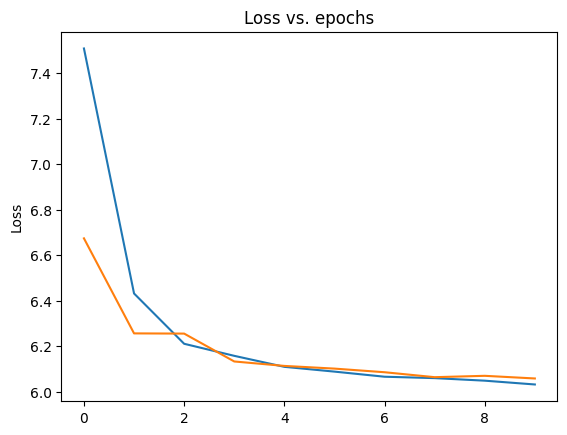

In [14]:
# plot loss
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss vs. epochs")
plt.ylabel("Loss")

In [20]:
# list all layers in econder_with_projection_head and print index and name
for i, layer in enumerate(encoder_with_projection_head.layers):
    print(i, layer.name)

0 input_14
1 model_12
2 contrastive_output_0
3 contrastive_output_1
4 regression_output_0
5 regression_output_1


In [21]:
model_2 = Model(inputs=encoder_with_projection_head.input, outputs=[encoder_with_projection_head.layers[2].output, encoder_with_projection_head.layers[3].output])
model_2.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_12 (Functional)       (None, 128)                  1185267   ['input_14[0][0]']            
                                                          2                                       
                                                                                                  
 contrastive_output_0 (Dens  (None, 128)                  16512     ['model_12[0][0]']            
 e)                                                                                               
                                                                                           

In [23]:
# merge the last 2 layers in a single layer and add a two regression heads
# from model_2
inputs = Input(shape=(320, 320, 1))
x = model_2(inputs)
# merge the last 2 layers in a single layer
x = layers.concatenate(x)
# add a two regression heads
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='linear')(x)
x = Dense(1, activation='linear')(x)

model_3 = Model(inputs=inputs, outputs=x)
model_3.summary()


# freezw the model except the last 3 layers
for layer in model_3.layers[:-3]:
    layer.trainable = False

# compile the model
learning_rate = 0.0001
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mse'])

# train the model
batch_size = 64
epochs = 10
history = model_3.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_17 (Functional)       [(None, 128),                1188569   ['input_16[0][0]']            
                              (None, 128)]                6                                       
                                                                                                  
 concatenate_2 (Concatenate  (None, 256)                  0         ['model_17[1][0]',            
 )                                                                   'model_17[1][1]']            
                                                                                           

Text(0, 0.5, 'Loss')

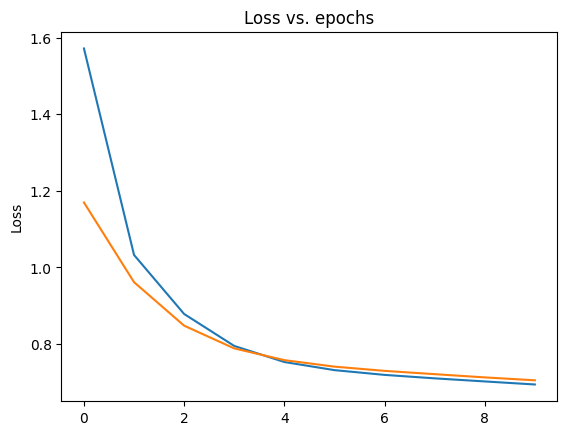

In [24]:
# plot loss
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss vs. epochs")
plt.ylabel("Loss")


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow_addons as tfa

def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

def add_projection_head(input_shape, encoder, embedding_dim, num_tasks):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    
    contrastive_outputs = [Dense(embedding_dim, activation='linear', name=f"contrastive_output_{i}")(features) for i in range(num_tasks)]

    model = Model(inputs=inputs, outputs=contrastive_outputs)
    return model

def add_regression_head(input_shape, encoder_with_projection_head, num_tasks):
    inputs = Input(shape=input_shape)
    features = encoder_with_projection_head(inputs)
    
    regression_outputs = [Dense(1, activation='linear', name=f"regression_output_{i}")(features[i]) for i in range(num_tasks)]

    model = Model(inputs=inputs, outputs=regression_outputs)
    return model

class SupConModel(Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = create_encoder(input_shape)
        self.sup_model = add_projection_head(input_shape, self.encoder, embedding_dim, num_tasks)
        self.regression_model = add_regression_head(input_shape, self.encoder, num_tasks)
        self.temperature = 0.05
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.loss_p_tracker = tf.keras.metrics.Mean(name="loss_p")
        self.loss_v_tracker = tf.keras.metrics.Mean(name="loss_v")
        self.loss_reg_tracker = tf.keras.metrics.Mean(name="loss_reg")
        self.loss_reg_p_tracker = tf.keras.metrics.Mean(name="loss_reg_p")
        self.loss_reg_v_tracker = tf.keras.metrics.Mean(name="loss_reg_v")
        
    def call(self, inputs):
        return self.sup_model(inputs)
    
    def train_step(self, data):
        X, y = data  
        y_p = y[:, 0]
        y_v = y[:, 1]
        
        with tf.GradientTape() as tape:
            y_pred = self.sup_model(X)
            loss_p = self.supervised_contrastive_loss(y_p, y_pred[0])
            loss_v = self.supervised_contrastive_loss(y_v, y_pred[1])
            loss = loss_p + loss_v
            
        gradients = tape.gradient(loss, self.sup_model.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.sup_model.trainable_weights)
        )
        
        with tf.GradientTape() as tape:
            y_reg_pred = self.regression_model(X)
            loss_reg_p = tf.keras.losses.MSE(y_p, y_reg_pred[0])
            loss_reg_v = tf.keras.losses.MSE(y_v, y_reg_pred[1])
            loss_reg = loss_reg_p + loss_reg_v
        
        gradients_reg = tape.gradient(loss_reg, self.regression_model.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients_reg, self.regression_model.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        self.loss_p_tracker.update_state(loss_p)
        self.loss_v_tracker.update_state(loss_v)
        
        self.loss_reg_tracker.update_state(loss_reg)
        self.loss_reg_p_tracker.update_state(loss_reg_p)
        self.loss_reg_v_tracker.update_state(loss_reg_v)
   
        return {"loss": self.loss_tracker.result(), 
                "loss_p": self.loss_p_tracker.result(), "loss_v": self.loss_v_tracker.result(),
                "loss_reg": self.loss_reg_tracker.result(),
                "loss_reg_p": self.loss_reg_p_tracker.result(), "loss_reg_v": self.loss_reg_v_tracker.result()}

    def test_step(self, data):
        X, y = data
        y_p = y[:, 0]
        y_v = y[:, 1]
               
        y_pred = self.sup_model(X, training=False)
        loss_p = self.supervised_contrastive_loss(y_p, y_pred[0])
        loss_v = self.supervised_contrastive_loss(y_v, y_pred[1])
        loss = loss_p + loss_v
        
        y_reg_pred = self.regression_model(X, training=False)   
        
        loss_reg_p = tf.keras.losses.MSE(y_p, y_reg_pred[0])
        loss_reg_v = tf.keras.losses.MSE(y_v, y_reg_pred[1])
        loss_reg = loss_reg_p + loss_reg_v
        
        self.loss_tracker.update_state(loss)
        self.loss_p_tracker.update_state(loss_p)
        self.loss_v_tracker.update_state(loss_v)
        
        self.loss_reg_tracker.update_state(loss_reg)
        self.loss_reg_p_tracker.update_state(loss_reg_p)
        self.loss_reg_v_tracker.update_state(loss_reg_v)

        return {"loss": self.loss_tracker.result(),
                "loss_p": self.loss_p_tracker.result(), "loss_v": self.loss_v_tracker.result(),
                "loss_reg": self.loss_reg_tracker.result(),
                "loss_reg_p": self.loss_reg_p_tracker.result(), "loss_reg_v": self.loss_reg_v_tracker.result()}

    def supervised_contrastive_loss(self, labels, feature_vectors):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]
    
    

model = SupConModel()

# Compile the model
learning_rate = 0.0001
model.compile()

batch_size = 64
epochs = 10

# Train the model
model.fit(
    x=X_train, 
    y=y_train,
    batch_size=batch_size, epochs=epochs, validation_split=0.2,
)


ValueError: Input 0 of layer "regression_output_0" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (128,)

In [ ]:
dropout_rate = 0.2
hidden_units = 128
num_classes = 4
num_epochs = 20
def create_classifier(encoder, trainable=False):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    #features = layers.Dropout(dropout_rate)(features)
    #features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

classifier = create_classifier(encoder, trainable=False)

history = classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs)



KeyboardInterrupt: 

In [ ]:
# evaluate model with x_test and y_test
loss, acc = classifier.evaluate(x=X_test, y=y_test)
print("loss: ", loss)
print("acc: ", acc)

Evaluating model with x_test and y_test...
120/120 [==============================] - 2s 14ms/step - loss: 0.1364 - sparse_categorical_accuracy: 0.9718
loss:  0.136428564786911
acc:  0.9718456864356995


In [ ]:
# test model with only manta images -> manta_test with first alph of y_test
y_test_manta = y_test[:len(y_test)//2]
#manta_test = X_test[:len(X_test)//2]

accuracy = classifier.evaluate(x=manta_test, y=y_test_manta)[1]

60/60 [==============================] - 1s 16ms/step - loss: 0.0651 - sparse_categorical_accuracy: 0.9838


In [ ]:


# Assuming you have your images and features preprocessed and stored in numpy arrays
# image1, image2, laser_power, velocity

# Define the base network architecture
def create_base_network():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32))
    return model

# Create two instances of the base network
base_network = create_base_network()
image1_network = models.Model(inputs=base_network.input, outputs=base_network.output)
image2_network = models.Model(inputs=base_network.input, outputs=base_network.output)

# Define the distance layer
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, image1, image2, laser_power1, velocity1, laser_power2, velocity2):
        image_distance = tf.reduce_sum(tf.square(image1 - image2), axis=-1)
        laser_power_distance = tf.square(laser_power1 - laser_power2)
        velocity_distance = tf.square(velocity1 - velocity2)
        return image_distance + laser_power_distance + velocity_distance
    

class ContrastiveLossLaserPower(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred, laser_power1, laser_power2):
        # Calculate the margin as a function of laser power
        margin_laser_power = tf.abs(laser_power1 - laser_power2)

        square_pred = tf.square(y_pred)
        margin_square_laser_power = tf.square(tf.maximum(margin_laser_power - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square_laser_power)

class ContrastiveLossVelocity(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred, velocity1, velocity2):
        # Calculate the margin as a function of velocity
        margin_velocity = tf.abs(velocity1 - velocity2)

        square_pred = tf.square(y_pred)
        margin_square_velocity = tf.square(tf.maximum(margin_velocity - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square_velocity)
    
class ContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred, laser_power1, velocity1, laser_power2, velocity2):
        # Calculate the margins as functions of laser power and velocity
        margin_laser_power = tf.abs(laser_power1 - laser_power2)
        margin_velocity = tf.abs(velocity1 - velocity2)

        square_pred = tf.square(y_pred)
        margin_square_laser_power = tf.square(tf.maximum(margin_laser_power - y_pred, 0))
        margin_square_velocity = tf.square(tf.maximum(margin_velocity - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * (margin_square_laser_power + margin_square_velocity))




# Create the distance layer
distance = distance_layer(image1_network.output, image2_network.output, laser_power1, velocity1, laser_power2, velocity2)
model = models.Model(inputs=[image1_network.input, image2_network.input, laser_power1, velocity1, laser_power2, velocity2], outputs=distance)

# Compile the model
model.compile(optimizer='adam', loss='contrastive_loss')  # You need to define 'contrastive_loss'

# Train the model
# model.fit([image1, image2, laser_power, velocity], labels, epochs=10)


NameError: name 'distance_layer' is not defined

In [ ]:
class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.contrastive_loss_laser_power = ContrastiveLossLaserPower()
        self.contrastive_loss_velocity = ContrastiveLossVelocity()

    def call(self, y_true, y_pred, laser_power1, laser_power2, velocity1, velocity2):
        loss_laser_power = self.contrastive_loss_laser_power(y_true, y_pred, laser_power1, laser_power2)
        loss_velocity = self.contrastive_loss_velocity(y_true, y_pred, velocity1, velocity2)
        return self.alpha * loss_laser_power + (1 - self.alpha) * loss_velocity


In [ ]:
class ContrastiveLossLaserPower(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred, laser_power1, laser_power2):
        # Calculate the margin as a function of laser power
        margin_laser_power = tf.abs(laser_power1 - laser_power2)

        square_pred = tf.square(y_pred)
        margin_square_laser_power = tf.square(tf.maximum(margin_laser_power - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square_laser_power)

class ContrastiveLossVelocity(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred, velocity1, velocity2):
        # Calculate the margin as a function of velocity
        margin_velocity = tf.abs(velocity1 - velocity2)

        square_pred = tf.square(y_pred)
        margin_square_velocity = tf.square(tf.maximum(margin_velocity - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square_velocity)
    
model.compile(optimizer='adam', loss=[ContrastiveLossLaserPower(), ContrastiveLossVelocity()])

NameError: name 'model' is not defined